<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/LusitanHypersonicv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Sensitivity: Flight Mach 3.5 to 6.0 ===
Mach   |   Isp (s)   |   Thrust (kN)   |   M_exit
3.50   |     5213     |     2.48        |    3.85
3.75   |     5198     |     2.65        |    4.17
4.00   |     5145     |     2.80        |    4.46
4.25   |     5070     |     2.93        |    4.73
4.50   |     4990     |     3.06        |    5.00
4.75   |     4905     |     3.17        |    5.27
5.00   |     4818     |     3.28        |    5.53
5.25   |     4730     |     3.38        |    5.80
5.50   |     4640     |     3.48        |    6.07
5.75   |     4551     |     3.56        |    6.34
6.00   |     4462     |     3.65        |    6.61


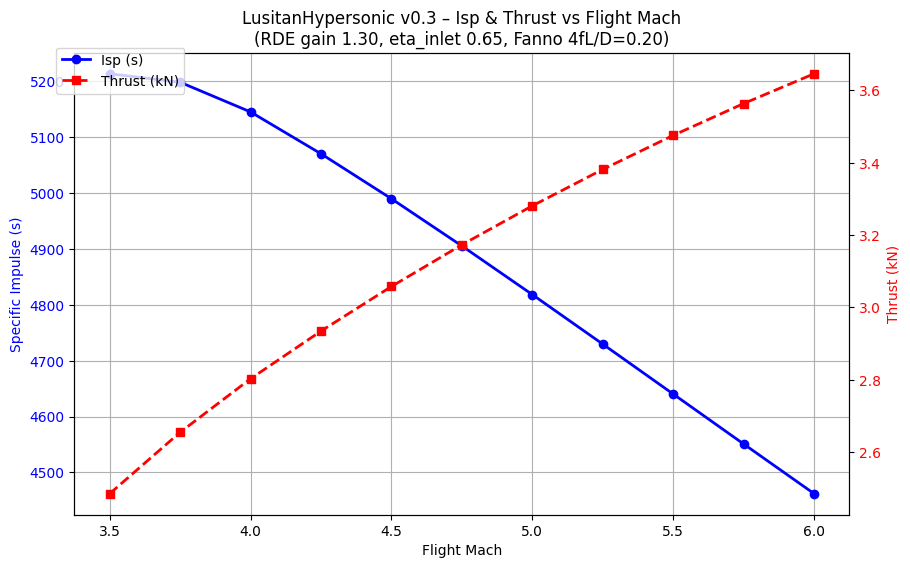

In [1]:
#!/usr/bin/env python3
"""
LusitanHypersonic v0.3 – Realistic RDE-Augmented Scramjet 1D Analysis
- Loop: Flight Mach 3.5 to 6.0 → Isp vs Mach plot
- Isolator: Real Fanno flow (friction in constant-area duct)
"""

import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd  # para CSV opcional

class LusitanHypersonicEngine:
    def __init__(self, flight_mach=4.0, phi=0.8, eta_inlet=0.65, rde_gain=1.30):
        self.gamma = 1.4
        self.R = 287.0
        self.cp = self.gamma * self.R / (self.gamma - 1)

        self.flight_mach = flight_mach
        self.alt = 25000.0
        self.T0 = 221.5
        self.p0 = 2550.0
        self.a0 = np.sqrt(self.gamma * self.R * self.T0)
        self.u0 = self.flight_mach * self.a0

        self.A_capture = 0.05  # m²

        self.h_fuel = 120e6
        self.f_stoich = 0.029
        self.phi = phi
        self.eta_comb = 0.92

        self.eta_inlet = eta_inlet
        self.eta_nozzle = 0.98
        self.rde_gain = rde_gain

        # Fanno isolator parameters (realistic for Mach 4-6 scramjet)
        self.fanno_4fL_D = 0.20  # 4 Cf L/D ≈ 0.15-0.30 typical; aqui 0.20 médio

    def total_conditions(self, M, T, p):
        Tt = T * (1 + (self.gamma - 1)/2 * M**2)
        pt = p * (Tt / T)**(self.gamma / (self.gamma - 1))
        return Tt, pt

    def fanno_mach_solver(self, M_in, four_fL_D):
        """
        Solve for M_out given M_in and integrated friction parameter 4fL/D
        Using standard Fanno relation: (4fL*/D) from M to sonic
        """
        def fanno_integral(M):
            term1 = (1 - M**2) / (self.gamma * M**2)
            term2 = (self.gamma + 1)/(2 * self.gamma) * np.log(
                ( (self.gamma + 1) * M**2 ) / (2 + (self.gamma - 1) * M**2 )
            )
            return term1 + term2

        Lstar_in = fanno_integral(M_in)   # from M_in to M=1
        Lstar_out = Lstar_in - four_fL_D  # subtract the friction length

        if Lstar_out < 0:
            return 1.0  # choked

        def eq(M_out):
            return fanno_integral(M_out) - Lstar_out

        M_out_guess = M_in * 0.9 if M_in > 1.5 else M_in
        M_out = fsolve(eq, M_out_guess)[0]
        M_out = max(0.1, min(M_out, M_in))  # bounds
        return M_out

    def solve(self):
        res = {}

        # 0 Freestream
        Tt0, pt0 = self.total_conditions(self.flight_mach, self.T0, self.p0)
        res[0] = {'M': self.flight_mach, 'T': self.T0, 'p': self.p0, 'u': self.u0, 'Tt': Tt0, 'pt': pt0}

        # 1 Inlet exit (supersonic diffusion)
        M1 = min(2.5, self.flight_mach * 0.65)  # rough: ~Mach 2.0-2.5 for flight 4-6
        Tt1 = Tt0
        pt1 = pt0 * self.eta_inlet
        T1 = Tt1 / (1 + (self.gamma-1)/2 * M1**2)
        p1 = pt1 * (1 + (self.gamma-1)/2 * M1**2)**(-self.gamma/(self.gamma-1))
        u1 = M1 * np.sqrt(self.gamma * self.R * T1)
        res[1] = {'M': M1, 'T': T1, 'p': p1, 'u': u1, 'Tt': Tt1, 'pt': pt1}

        # 2 Isolator - REAL FANNO FLOW
        M2 = self.fanno_mach_solver(M1, self.fanno_4fL_D)
        Tt2 = Tt1  # adiabatic
        # pt loss from Fanno formula
        pt2 = pt1 * ( (1 + (self.gamma-1)/2 * M1**2) / (1 + (self.gamma-1)/2 * M2**2) )**(
            self.gamma / (self.gamma - 1)
        ) * (M2 / M1)  # approx from integrated relations
        T2 = Tt2 / (1 + (self.gamma-1)/2 * M2**2)
        p2 = pt2 * (1 + (self.gamma-1)/2 * M2**2)**(-self.gamma/(self.gamma-1))
        u2 = M2 * np.sqrt(self.gamma * self.R * T2)
        res[2] = {'M': M2, 'T': T2, 'p': p2, 'u': u2, 'Tt': Tt2, 'pt': pt2}

        # 3 Combustor (heat + RDE gain)
        q = self.phi * self.f_stoich * self.h_fuel * self.eta_comb
        Tt3 = Tt2 + q / self.cp
        pt3 = pt2 * self.rde_gain
        M3 = 1.60
        T3 = Tt3 / (1 + (self.gamma-1)/2 * M3**2)
        p3 = pt3 * (1 + (self.gamma-1)/2 * M3**2)**(-self.gamma/(self.gamma-1))
        u3 = M3 * np.sqrt(self.gamma * self.R * T3)
        res[3] = {'M': M3, 'T': T3, 'p': p3, 'u': u3, 'Tt': Tt3, 'pt': pt3}

        # 4 Nozzle
        pt4 = pt3 * self.eta_nozzle
        def nozzle_eq(M):
            return pt4 / self.p0 * (1 + (self.gamma-1)/2 * M**2)**(-self.gamma/(self.gamma-1)) - 1.0
        M4_guess = self.flight_mach + 2.0
        M4 = fsolve(nozzle_eq, M4_guess)[0]
        Tt4 = Tt3
        T4 = Tt4 / (1 + (self.gamma-1)/2 * M4**2)
        p4 = self.p0
        u4 = M4 * np.sqrt(self.gamma * self.R * T4)
        res[4] = {'M': M4, 'T': T4, 'p': p4, 'u': u4, 'Tt': Tt4, 'pt': pt4}

        # Performance
        rho0 = self.p0 / (self.R * self.T0)
        m_dot_air = rho0 * self.u0 * self.A_capture
        m_dot_fuel = m_dot_air * self.phi * self.f_stoich
        Ae_approx = self.A_capture * 4.0
        thrust = m_dot_air * (u4 - self.u0) + (p4 - self.p0) * Ae_approx
        isp = thrust / (m_dot_fuel * 9.81) if m_dot_fuel > 0 else 0
        eta_thermal = 0.5 * (u4**2 - self.u0**2) / q if q > 0 else 0

        self.results = res
        self.perf = {'thrust_N': thrust, 'isp_s': isp, 'eta_thermal': eta_thermal, 'M_exit': M4, 'u_exit': u4}
        return res, self.perf


def run_sensitivity_loop():
    mach_values = np.arange(3.5, 6.01, 0.25)
    isp_list = []
    m_exit_list = []
    thrust_list = []

    print("=== Sensitivity: Flight Mach 3.5 to 6.0 ===")
    print("Mach   |   Isp (s)   |   Thrust (kN)   |   M_exit")

    for mach in mach_values:
        engine = LusitanHypersonicEngine(flight_mach=mach, phi=0.8, eta_inlet=0.65, rde_gain=1.30)
        _, perf = engine.solve()
        isp_list.append(perf['isp_s'])
        thrust_list.append(perf['thrust_N'] / 1000)
        m_exit_list.append(perf['M_exit'])
        print(f"{mach:4.2f}   |   {perf['isp_s']:6.0f}     |   {perf['thrust_N']/1000:6.2f}        |   {perf['M_exit']:5.2f}")

    # Plot Isp vs Flight Mach
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(mach_values, isp_list, 'b-o', lw=2, label='Isp (s)')
    ax1.set_xlabel('Flight Mach')
    ax1.set_ylabel('Specific Impulse (s)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(mach_values, thrust_list, 'r--s', lw=2, label='Thrust (kN)')
    ax2.set_ylabel('Thrust (kN)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('LusitanHypersonic v0.3 – Isp & Thrust vs Flight Mach\n'
              '(RDE gain 1.30, eta_inlet 0.65, Fanno 4fL/D=0.20)')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    plt.show()

    # Opcional: salvar em CSV
    df = pd.DataFrame({
        'Flight_Mach': mach_values,
        'Isp_s': isp_list,
        'Thrust_kN': thrust_list,
        'M_exit': m_exit_list
    })
    # df.to_csv('lusitan_sensitivity.csv', index=False)
    # print("Dados salvos em 'lusitan_sensitivity.csv'")


if __name__ == "__main__":
    run_sensitivity_loop()